# Dixon-Coles Model

The Dixon-Coles model corrects for the basic model's underestimation of draws and it also incorporates a time component so that recent matches are considered more important in calculating average goals rate

## Dataset

We'll initially pull the match results for the EPL 2017/18 season from football-data.co.uk.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam
from scipy.optimize import minimize

plt.style.use('ggplot')

epl_1718 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv")
epl_1718 = epl_1718[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1718.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Arsenal,Leicester,4,3
1,Brighton,Man City,0,2
2,Chelsea,Burnley,2,3
3,Crystal Palace,Huddersfield,0,3
4,Everton,Stoke,1,0


## Basic Poisson Model (BP)

Essentially, we treat the number of goals scored by each team as two independent Poisson distributions. The shape of each distribution is determined by the average number of goals scored by that team. A little reminder on the mathematical definition of the Poisson distribution:

$$ P(x) = \frac{e^{-\lambda} \lambda ^x }{x!}, \lambda \gt 0 $$

In our case, $\lambda$ represents the team's average or expected goal scoring rate. The Poisson distribution is a decent approximation of a team's scoring frequency. All of the model's discussed here agree on this point; the disagreement centres on how to calculate $\lambda_{home}$ and $\lambda_{away}$.

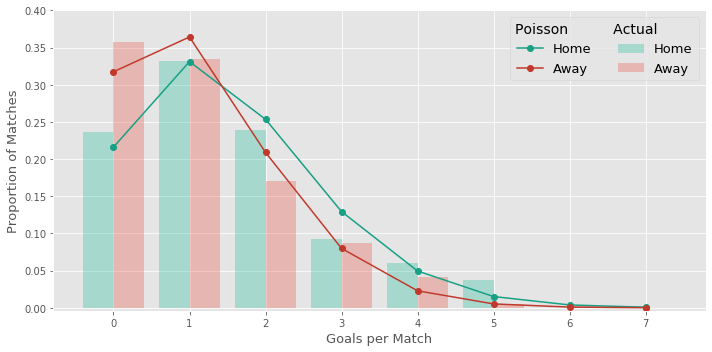

In [2]:
poisson_pred = np.column_stack([[poisson.pmf(i, epl_1718.mean()[j]) for i in range(8)] for j in range(2)])

plt.figure(figsize=(10,5))
plt.hist(epl_1718[['HomeGoals', 'AwayGoals']].values, range(9), 
         alpha=0.3, label=['Home', 'Away'],density=True, color=["#1abc9c", "#e74c3c"])
leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#16a085')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson          Actual        ", prop = {'size':'14'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

We can formulate the model in mathematical terms:$$
P(X_{i,j} = x, Y_{j,i} = y) = \frac{e^{-\lambda} \lambda^x }{x!} \frac{e^{-\mu} \mu^y }{y!} \text{, where } \lambda = \alpha_i \beta_j \gamma \text{ , }  \mu = \alpha_j \beta_i
$$

In this equation, $i$ and $j$ refer to the home and away teams, respectively; $\alpha$ and $\beta$ denote each team's attack and defensive strength, respectively, while $\gamma$ represents the home advantage factor. So, we need to calculate $\alpha$ and $\beta$ for each team, as well as $\gamma$ (the home field advantage term- it's the same value for every team).

In [3]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([epl_1718[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1718[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      720
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1052.3
Date:                Tue, 07 Jan 2020   Deviance:                       796.97
Time:                        19:35:18   Pearson chi2:                     683.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [4]:
pred_arsenal = poisson_model.predict(pd.DataFrame(data={'team': 'Arsenal', 'opponent': 'Southampton',
                                       'home':1},index=[1]))


pred_southampton= poisson_model.predict(pd.DataFrame(data={'team': 'Southampton', 'opponent': 'Arsenal',
                                       'home':0},index=[1]))

print(pred_arsenal)
print(pred_southampton)

1    2.426661
dtype: float64
1    0.862952
dtype: float64


In [5]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
ars_sou = simulate_match(poisson_model, 'Arsenal', 'Southampton', max_goals=10)
print(ars_sou[0:5, 0:5])

[[0.03726828 0.03216072 0.01387657 0.0039916  0.00086114]
 [0.09043748 0.07804317 0.03367374 0.00968627 0.0020897 ]
 [0.10973057 0.09469217 0.04085738 0.01175265 0.00253549]
 [0.08875964 0.07659527 0.033049   0.00950656 0.00205093]
 [0.05384739 0.04646769 0.02004968 0.0057673  0.00124423]]


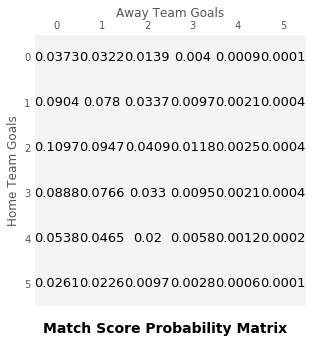

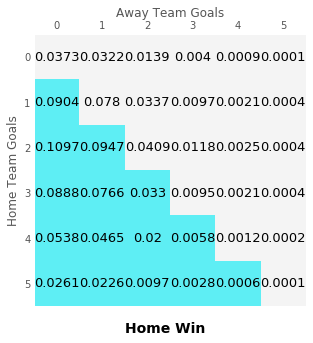

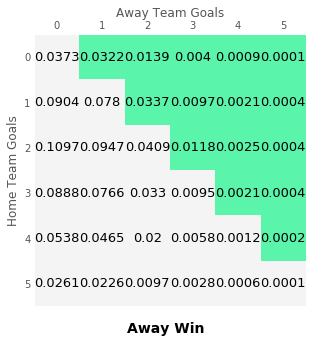

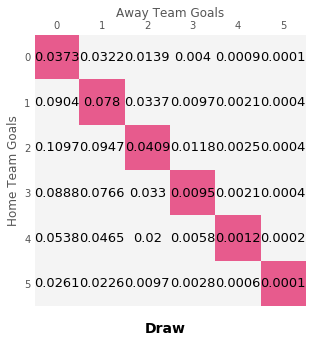

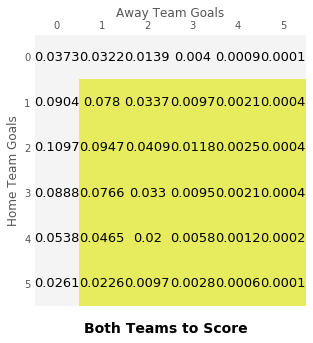

In [6]:
from matplotlib.colors import ListedColormap

def matrix_gif(matrix, colour_matrix, colour_map, subtitle="", heatmap=False, alpha=0.8):
    fig, ax1 = plt.subplots(1, figsize=(5,5))
    if heatmap:
        ax1.matshow(matrix, alpha=alpha)
    else:
        ax1.matshow(colour_matrix, cmap=colour_map, alpha=alpha)
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    ax1.grid(which='major', axis='both', linestyle='')
    ax1.set_xlabel('Away Team Goals', fontsize=12)
    ax1.set_ylabel('Home Team Goals', fontsize=12)
    ax1.xaxis.set_label_position('top')
    nrows, ncols = matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = matrix[i][j]
            ax1.text(j, i, str(round(c,4)), va='center', ha='center', size=13)
    plt.figtext(0.5, 0.05, subtitle, horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
    
    return fig

cmap = ListedColormap(['w', '#04f5ff', '#00ff85', '#e90052'])
matrix = simulate_match(poisson_model, 'Arsenal', 'Southampton', max_goals=5)
matn = len(matrix)
matrix_gif(matrix, matrix, ListedColormap(['w']), heatmap=True, 
           alpha=0.6, subtitle="Match Score Probability Matrix").savefig("match_matrix_0.png")

plt.close()
btts = np.zeros((matn, matn))
for j in range(1,matn):
    btts[j,1:] = 1

for t,(mat,colour,subtitle) in enumerate(zip([np.zeros((matn, matn)), np.tril(np.ones((matn,matn)),-1),
                            np.triu(np.ones((matn,matn))*2,1), np.diag([3]*matn), btts],
                          ['w', '#04f5ff', '#00ff85', '#e90052','#EAF205'],
                                   ['Match Score Probability Matrix', 'Home Win', 'Away Win', 'Draw', 'Both Teams to Score'])):
    matrix_gif(matrix, mat, ListedColormap(['w'] + [colour]), heatmap=False, 
               alpha=0.6, subtitle=subtitle).savefig("match_matrix_{}.png".format(t+1))
    plt.show()
    plt.close()


First, <a href='http://www.90minut.pl/misc/maher.pdf'>published by Maher in 1982</a>, the BP model still serves a good starting point from which you can add features that more closely reflect the reality. That brings us onto the Dixon Coles (DC) model.

## Dixon-Coles Model

In their 1997 paper, Mark Dixon and Stuart Coles proposed two specific improvements to the BP model:

* Introduce an interaction term to correct underestimated frequency of low scoring matches
* Apply time decay component so that recent matches are weighted more strongly

The authors claim that low score results (0-0, 1-0, 0-1 and 1-1) are inherently under-reported by the BP model. In the paper, they provide some analysis that supports their case (though I wouldn't call their approach particularly rigorous). The matrix below shows the average difference between actual and model predicted scorelines for the 2005/06 season all the way up to the 2017/18 season. Green cells imply the model underestimated those scorelines, while red cells suggest overestimation - the colour strength indicates the level of disagreement.

In [7]:
def poiss_actual_diff(football_url, max_goals):
    epl_1718 = pd.read_csv(football_url)
    epl_1718 = epl_1718[['HomeTeam','AwayTeam','FTHG','FTAG']]
    epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals)] \
                 for team_avg in [epl_1718['HomeGoals'].mean(), epl_1718['AwayGoals'].mean()]]
    return np.outer(np.array(team_pred[0]), np.array(team_pred[1])) - \
        np.array([sum((epl_1718['HomeGoals']==i) & (epl_1718['AwayGoals']==j)) 
                  for i in range(max_goals) for j in range(max_goals)]).reshape((6,6))/len(epl_1718)

year_arrays = []
for year in range(2005,2018):
    year_arrays.append(poiss_actual_diff("http://www.football-data.co.uk/mmz4281/{}{}/E0.csv".format(
        str(year)[-2:], str(year+1)[-2:]),6))

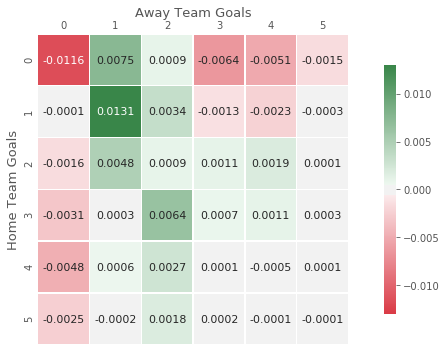

In [8]:
cmap = sns.diverging_palette(10, 133, as_cmap=True)

plt.figure(figsize=(10,5))

ax = sns.heatmap(np.mean(year_arrays, axis=0), annot=True, fmt='.4f', cmap=cmap, vmin=-0.013, vmax=.013, center=0.00,
            square=True, linewidths=.4, annot_kws={"size": 11}, cbar_kws={"shrink": .8})
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(which='major', axis='both', linestyle='')

ax.set_xlabel('Away Team Goals', fontsize=13)
ax.set_ylabel('Home Team Goals', fontsize=13)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()
plt.show()

There does seem to be an issue around low scoring draws, though it is less apparent with 1-0 and 0-1 results. The Dixon-Coles (DC) model applies a correction to the BP model. It can be written in these mathematical terms:

$$ P\left(X_{i,j} = x, Y_{j,i} = y \right) = \tau_{\lambda, \mu}(x) \frac{e^{-\lambda} \lambda^x }{x!} \frac{e^{-\mu} \mu^y }{y!} \\ \text{where } \quad \lambda = \alpha_i \beta_j \gamma \quad \mu = \alpha_j \beta_i \\ \tau_{\lambda, \mu}(x, y) = \begin{cases} 1 - \lambda \mu \rho & \text{if $x = y = 0$} \\ 1 - \lambda \rho & \text{if $x=0$, $y=1$} \\ 1 + \mu \rho & \text{if $x=0$, $y=1$} \\ 1 - \rho & \text{if $x = y = 1$} \\ 1 & \text{otherwise} \\ \end{cases} $$
The key difference over the BP model is the addition of the $\tau$ (tau) function. It is highly dependent on the $\rho$ (rho) parameter, which controls the strength of the correction (note: setting $\rho$=0 equates to the standard BP model). We can easily convert $\tau_{\lambda, \mu}(x, y)$ to Python code.

In [9]:
def rho_correction(x, y, lambda_x, mu_y, rho):
    if x==0 and y==0:
        return 1- (lambda_x * mu_y * rho)
    elif x==0 and y==1:
        return 1 + (lambda_x * rho)
    elif x==1 and y==0:
        return 1 + (mu_y * rho)
    elif x==1 and y==1:
        return 1 - rho
    else:
        return 1.0

Unfortunately, you can't just update your match score matrix with this function; you need to recalculate the various coefficients that go into the model. And unfortunately again, you can't just implement an off the shelf generalised linear model, as we did before. We have to construct the likelihood function and find the coefficients that maximise it- a technique known as Maximum Likelihood Estimation. With matches indexed $k=1,\dots,N$ and corresponding scores ($x_k$, $y_k$), this is the likelihood function that we seek to maximise:

$$
L(\alpha_i, \beta_i, \rho, \gamma, i=1,\dots,n) = \prod_{k=1}^{N} \tau_{\lambda_k,\mu_k}(x_k, y_k) \ \frac{e^{-\lambda} \lambda^{x_k} }{x_k!} \frac{e^{-\mu} \mu^{y_k} }{y_k!}
\\ \text{where } \quad \lambda_k = \alpha_{i(k)} \beta_{j(k)} \gamma \quad \mu_k = \alpha_{j(k)} \beta_{i(k)}
$$

In this equation, $i(k)$ and $j(k)$ respectively denote the indices of the home and away teams in match $k$. For a few different reasons (numerical precision, practicality, etc.), we'll actually maximise the log-likelihood function. As the logarithm is a strictly increasing function (i.e. $\log(b) \gt \log(a) \ \forall \ b \gt a$), both likelihood functions are maximised at the same point. Also, recall that $\log(a \ b) = \log(a) + \log(b)$. We can thus write the log-likelihood function in Python code.

In [10]:
def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
    lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
    return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
            np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

You may have noticed that <code>dc_log_like</code> included a transformation of $\lambda$ and $\mu$, where $\lambda = \exp(\alpha_i + \beta_j + \gamma)$ and $\mu = \exp(\alpha_j + \beta_i)$, so that we're essentially trying to calculate expected log goals. This is equivalent to the log link function in the previous BP glm implementation. It shouldn't really affect model accuracy, it just means that convergence of the maximisation algorithm should be easier as $\lambda, \mu \gt 0 \ \forall \ \alpha, \beta, \gamma$. Non-positive lambdas are not compatible with a Poisson distribution, so this would return warnings and/or errors during implementation.

We're now ready to find the parameters that maximise the log likelihood function. Basically, you design a function that takes a set of model parameters as an argument. You set some initial values and potentially include some constraints and select the appropriate optimisation algorithm. I've opted for scipy's minimise function (a possible alternative is fmin- note: the functions seek to minimise the negative log-likelihood). It employs a process analogous to gradient descent, so that the algorithm iteratively converges to the optimal parameter set. The computation can be quite slow as it's forced to approximate the derivatives. If you're not as lazy as me, you could potentially speed it up by manually constructing the partial derivatives.

In line with the original Dixon Coles paper and the opisthokonta blog, I've added the constraint that $\frac{1}{n}\sum_{i} \alpha_{i}=1$ (i.e. the average attack strength value is 1). This step isn't strictly necessary, but it means that it should return a unique solution (otherwise, the model would suffer from overparamterisation and each execution would return different coefficients).

Okay, we're ready to find the coefficients that maximise the log-likelihood function for the 2017/18 EPL season.

In [11]:
def solve_parameters(dataset, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("Something's not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0, 1.0]) # rho (score correction), gamma (home advantage)
                                     ))
    def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like(row.HomeGoals, row.AwayGoals, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                     score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], rho, gamma) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints, **kwargs)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x))

In [12]:
params = solve_parameters(epl_1718)

/home/igormago/anaconda3/envs/DeepFootball/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/home/igormago/anaconda3/envs/DeepFootball/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1050.8007455241807
            Iterations: 57
            Function evaluations: 2594
            Gradient evaluations: 57


In [16]:
params

{'attack_Arsenal': 1.447580389592052,
 'attack_Bournemouth': 0.9564229414872817,
 'attack_Brighton': 0.6847101427114513,
 'attack_Burnley': 0.6983185051691245,
 'attack_Chelsea': 1.257218836235469,
 'attack_Crystal Palace': 0.949335356067868,
 'attack_Everton': 0.9376960471657004,
 'attack_Huddersfield': 0.489320676916342,
 'attack_Leicester': 1.1898978127538342,
 'attack_Liverpool': 1.5643627348213833,
 'attack_Man City': 1.7860079262746194,
 'attack_Man United': 1.3309451360190003,
 'attack_Newcastle': 0.7670340746971396,
 'attack_Southampton': 0.7651661902610687,
 'attack_Stoke': 0.7195876545226527,
 'attack_Swansea': 0.4664566048085095,
 'attack_Tottenham': 1.4273443130746102,
 'attack_Watford': 0.9338638639786544,
 'attack_West Brom': 0.5837427711767712,
 'attack_West Ham': 1.0449880222664694,
 'defence_Arsenal': -0.9058215245014457,
 'defence_Bournemouth': -0.758457307860378,
 'defence_Brighton': -0.894606276292263,
 'defence_Burnley': -1.2267074222956549,
 'defence_Chelsea': -1.

In [17]:
def calc_means(param_dict, homeTeam, awayTeam):
    return [np.exp(param_dict['attack_'+homeTeam] + param_dict['defence_'+awayTeam] + param_dict['home_adv']),
            np.exp(param_dict['defence_'+homeTeam] + param_dict['attack_'+awayTeam])]

def dixon_coles_simulate_match(params_dict, homeTeam, awayTeam, max_goals=10):
    team_avgs = calc_means(params_dict, homeTeam, awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in team_avgs]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    correction_matrix = np.array([[rho_correction(home_goals, away_goals, team_avgs[0],
                                                   team_avgs[1], params['rho']) for away_goals in range(2)]
                                   for home_goals in range(2)])
    output_matrix[:2,:2] = output_matrix[:2,:2] * correction_matrix
    return output_matrix

In [18]:
ars_sou_dc = dixon_coles_simulate_match(params, 'Arsenal', 'Southampton', max_goals=10)

In [19]:
# [Simple Poisson, Dixon-Coles]
print("Arsenal Win")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.tril(x, -1)), [ars_sou, ars_sou_dc])))))
print("Southampton Win")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.triu(x, 1)), [ars_sou, ars_sou_dc])))))
print("Draw")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.diag(x)), [ars_sou, ars_sou_dc])))))

Arsenal Win
Basic Poisson: 0.71846; Dixon-Coles: 0.70951
Southampton Win
Basic Poisson: 0.11446; Dixon-Coles: 0.10437
Draw
Basic Poisson: 0.16703; Dixon-Coles: 0.18607


As you can see, the DC model reports a higher probability of a draw compared to the BP model. In fact, you can plot the difference in the match score probability matrices between the two models.

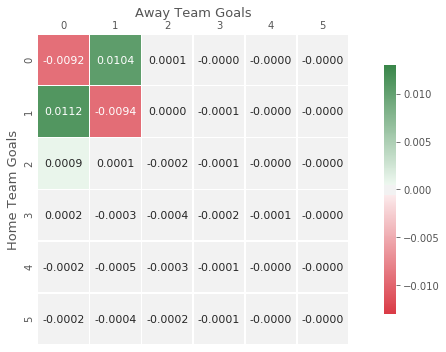

In [20]:

cmap = sns.diverging_palette(10, 133, as_cmap=True)

fig = plt.figure(figsize=(10,5)) 

ax = sns.heatmap(simulate_match(poisson_model, 'Arsenal', 'Southampton', max_goals=5) - \
                 dixon_coles_simulate_match(params, 'Arsenal', 'Southampton', max_goals=5), 
                 annot=True, fmt='.4f', cmap=cmap, vmin=-0.013, vmax=.013, center=0.00,
                 square=True, linewidths=.5, annot_kws={"size": 11}, cbar_kws={"shrink": .8})
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(which='major', axis='both', linestyle='')
ax.set_xlabel('Away Team Goals', fontsize=13)
ax.set_ylabel('Home Team Goals', fontsize=13)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
    
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()
plt.show()

In one way, this is a good plot. The correction was only intended to have an effect on 4 specific match results (0-0, 1-0, 0-1 and 1-1) and that's what has happened. On the other hand, that was alot of hard work to essentially tweak the existing model. And that's without even considering whether it was a beneficial adjustment. Without exploring that point any further, I'm going to discuss the second advancement introduced by the DC model.



## Dixon-Coles Time Decay Model

Crystal Palace famously (!) lost their opening seven fixtures of the 2017/18 EPL season, conceding 17 times and scoring zero goals. During his short reign, Ronald De Boer had disastrously tried to transform Palace into a more attractive, possession based side. Under their new manager, Roy Hodgson, they returned to their traditional counter attacking style. They recovered well from their poor start to end the season in a respectable 11th place.

Intuitively, if you were trying to predict a Crystal Palace match in January 2018, you would want the model to somewhat discount those losses in August and September 2017. That's the rationale behind adding a time component to the adjusted Poisson model outlined above. How exactly to down-weight those earlier games is the tricky part. Two weighting options offered in the Dixon-Coles paper are illustrated below.

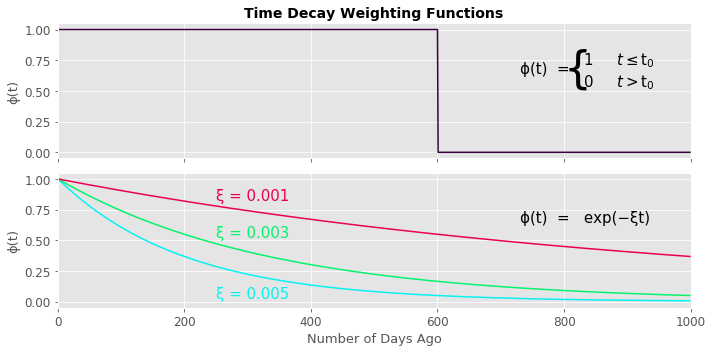

In [21]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(10,5))

ax1.plot(range(1000), [0 if y >600 else 1 for y in range(1000)], label='Component 1', color='#38003c', marker='')
ax2.plot(range(1000), np.exp([y*-0.005 for y in range(1000)]), label='Component 1', color='#07F2F2', marker='')
ax2.plot(range(1000), np.exp([y*-0.003 for y in range(1000)]), label='Component 1', color='#05F26C', marker='')
ax2.plot(range(1000), np.exp([y*-0.001 for y in range(1000)]), label='Component 1', color='#e90052', marker='')

ax1.set_ylim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax1.set_xlim([-0.5,1000])
ax2.set_xlim([-0.5,1000])
ax1.set_xticklabels([])
ax2.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax1.set_title("Time Decay Weighting Functions",size=14,fontweight='bold')
ax2.set_xlabel("Number of Days Ago",size=13)
ax1.set_ylabel("ϕ(t)",size=13)
ax2.set_ylabel("ϕ(t)",size=13)
ax1.text(830, 0.5, '1     $t \leq \mathregular{t_0}$\n0     $t > \mathregular{t_0}$',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax1.text(800, 0.5, '{',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=44)
ax1.text(730, 0.62, 'ϕ(t)  = ',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax2.text(730, 0.62, 'ϕ(t)  =   exp(−ξt)',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax2.text(250, 0.8, 'ξ = 0.001',
        verticalalignment='bottom', horizontalalignment='left',
        color='#e90052', fontsize=15)
ax2.text(250, 0.5, 'ξ = 0.003',
        verticalalignment='bottom', horizontalalignment='left',
        color='#05F26C', fontsize=15)
ax2.text(250, 0.0, 'ξ = 0.005',
        verticalalignment='bottom', horizontalalignment='left',
        color='#07F2F2', fontsize=15)
plt.tight_layout()
plt.show()

The first option forces the model to only consider matches within some predefined period (e.g. since the start of the season), while the negative exponential downweights match results more strongly going further into the past. The refined model can be written in these mathematical terms:

$$
L(\alpha_i, \beta_i, \rho, \gamma, i=1,\dots,n) = \prod_{k \in A_t}\{\tau_{\lambda_k,\mu_k}(x_k, y_k) \frac{e^{-\lambda} \lambda^{x_k} }{x_k!} \frac{e^{-\mu} \mu^{y_k} }{y_k!}\}^{\phi(t-t_k)}
$$

where $t_k$ represents the time that match $k$ was played, $A_t = \{k: t_k \lt t\}$ (i.e. set of matches played before time $t$), $\alpha$, $\beta$, $\gamma$ and $\tau$ are defined as before. $\phi$ represents the non-increasing weighting function. Copying the original Dixon Coles paper, we'll set $\phi(t)$ to be a negative exponential with rate $\xi$ (called xi). As before, we need to determine the parameters that maximise this likelihood function. We can't just feed this equation into a minimisation algorithm for various reasons (e.g. we can trivially maximise this function by increasing $\xi$). Instead, we'll fix $\xi$ and determine the remaining parameters the same way as before. We can thus write the corresponding log-likelihood function in the following Python code (recall $\log(a^b) = \log(a) \log(b)$). Note how $\xi$=0 equates to the standard non-time weighted log-likelihood function.

In [22]:
def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, xi=0):
    lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
    return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                              np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

To determine the optimal value of $\xi$, we'll select the model that makes the best predictions. Repeating the process in the Dixon-Coles paper, rather working on match score predictions, the models will be assessed on match result predictions. Essentially, the model that predicted the actual match results with the highest probability will be deemed the winner. An obvious flaw here is that only one match result is considered. For example, if the result was a home win, then the draw and away win probabilities are ignored. Alternative approaches could utilise Ranked Probability Scores or betting probabilities. But we'll keep things simple and replicate the Dixon Coles paper. We can redefine the objective in mathematical terms; we wish to find $\xi$ that maximises $S(\xi)$:

$$
S(\xi) = \sum^{N}_{k=1} (\delta^{H}_{k} \log p^{H}_{k} + \delta^{A}_{k} \log p^{A}_{k} + \delta^{D}_{k} \log p^{D}_{k})
$$
This looks more complicated than it really is. The $\delta$ terms just captures the match result e.g. $\delta^{H}_{k}$ = 1 if match $k$ ended in a home win, while the $p$ terms are simply the match result probabilities. For example, we can rewrite $p^{H}_{k}$ (probability of home win):

$$
p^{H}_{k} = \sum_{l,m \in B_H} P(X_k = l, Y_k = m), \text{ where } B_H = \{(l,m): l \gt m\}
$$
Each of these $p$ terms translates to the matrix operations outlined previously. One part that will change is the log likelihood function.

To assess the predictive accuracy of the model, we'll utilise an approach analogous to the validation set in machine learning. Let's say we're trying to predict the fixtures occurring on the 13th January 2018. With $\xi$ fixed to a specific value, we use all of the previous results in that season to build a model. We determine how that model predicted the actual results of those matches with the above equations. We move onto the next set of fixtures (say 20th January) and build the model again- this time including the 13th January games- and assess how well it predicted the results of those matches. We repeat this process for the rest of the 2017/18 season. When we sum up all of these predictions, you have calculated what is called the predicted profile log-likelihood for that value of $\xi$.

However, a new model must be built for each set of fixtures, so this can be quite slow. I have taken a few steps to speed up the computations:

* Predicting the fixtures for the last 100 days of the 2017/18 EPL season. This is probably preferable anyway, as early season predictions would be quite unreliable.
* Forming match days consisting of three consecutive days (i.e. on Saturday we'll try to predict matches taking place on Saturday, Sunday and Monday). This should be okay, as teams tend not to play more than once in three days (except at Christmas, which isn't included in the validation period).

We need to make some slight adjustments to the epl_1718 dataframe to include columns that represent the number of days since the completion of that fixture as well as the match result (home, away or draw).

In [23]:
epl_1718 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv")

pd.to_datetime(epl_1718[:1]['Date'],  format='%d/%m/%Y')
epl_1718['Date'] = pd.to_datetime(epl_1718['Date'],  format='%d/%m/%Y')

epl_1718['time_diff'] = (max(epl_1718['Date']) - epl_1718['Date']).dt.days

epl_1718 = epl_1718[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'time_diff']]
epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1718.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,FTR,time_diff
0,Arsenal,Leicester,4,3,H,275
1,Brighton,Man City,0,2,A,274
2,Chelsea,Burnley,2,3,A,274
3,Crystal Palace,Huddersfield,0,3,A,274
4,Everton,Stoke,1,0,H,274


With this dataframe, we're now ready to compare different values of $\xi$. To speed up this process even further, I made the code parallelisable and ran it across my computer's multiple (4) cores (see Python file).

Here's an example of how you would build a model for a given value of $\xi$.

In [ ]:
def solve_parameters_decay(dataset, xi=0.001, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("something not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0,1.0]) # rho (score correction), gamma (home advantage)
                                     ))
        
    def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, xi=xi):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                                  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like_decay(row.HomeGoals, row.AwayGoals, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                                      score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], 
                                      rho, gamma, row.time_diff, xi=xi) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x))

In [ ]:
params_xi= solve_parameters_decay(epl_1718, xi=0.0018)


In [ ]:
params_xi

In [ ]:
xi_vals = [0.0, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0016, 0.0018, 
            0.002, 0.0025, 0.003, 0.0035,  0.0035, 0.004,  0.0045, 0.005]

# I pulled the scores from files on my computer that had been generated seperately
#xi_scores = []
#for xi in xi_vals:
#    with open ('find_xi__{}.txt'.format(str(xi)[2:]), 'rb') as fp:
#        xi_scores.append(sum(pickle.load(fp)))
        
xi_scores = [-125.38424297397718, -125.3994150871104, -125.41582329299528, -125.43330024318175, -125.45167361727589,
              -125.47148572476918, -125.49165987944551, -125.51283291929082, -125.53570389317336, -125.5588181265923,
              -125.58171066742123, -125.64545123148538, -125.71506317675832, -125.78763678848986, -125.78763678848986,
              -125.8651515986525, -125.94721517841089, -126.03247674382676]

fig, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(xi_vals, xi_scores, label='Component 1', color='#F2055C', marker='o')
ax1.set_ylim([-126.20, -125.20])
ax1.set_xlim([-0.0001,0.0051])
#ax1.set_xticklabels([])
ax1.set_ylabel('S(ξ)', fontsize=13)
ax1.set_xlabel('ξ', fontsize=13)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_title("Predictive Profile Log-Likelihood (EPL 2017/18 Season)",size=14,fontweight='bold')
plt.show()

In [ ]:
epl_1318 = pd.DataFrame()
for year in range(13,17):
    temp = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}{}/E0.csv".format(year, year+1))
    temp['Date'] = pd.to_datetime(temp['Date'],  format='%d/%m/%y')
    epl_1318 = pd.concat((epl_1318, temp), sort=True)

temp = pd.read_csv("http://www.football-data.co.uk/mmz4281/{}{}/E0.csv".format(17, 18))
temp['Date'] = pd.to_datetime(temp['Date'],  format='%d/%m/%Y')
epl_1318 = pd.concat((epl_1318, temp), sort=True)

epl_1318['time_diff'] = (max(epl_1318['Date']) - epl_1318['Date']).dt.days
epl_1318 = epl_1318[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'time_diff']]
epl_1318 = epl_1318.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1318 = epl_1318.dropna(how='all')
epl_1318.head()

In [ ]:
xi_vals = [0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.00275, 0.003, 0.00325, 
            0.0035, 0.00375, 0.004, 0.00425, 0.0045, 0.005, 0.0055, 0.006]

# I pulled the scores from files on my computer that had been generated seperately
#xi_scores = []
#for xi in xi_vals:
#    with open ('find_xi_5season_{}.txt'.format(str(xi)[2:]), 'rb') as fp:
#        xi_scores.append(sum(pickle.load(fp)))

xi_scores =  [-127.64548699733858, -126.88558052909376, -126.24253680407995, -125.75657140537645, -125.43198691100818,
               -125.24473381373896, -125.1929173322124, -125.16314084998176, -125.15259048041912, -125.15741294807299,
               -125.17611832471187, -125.20427802084305, -125.24143128833828, -125.2863163741079, -125.39161839279092,
               -125.51241118364625, -125.64269122223465]

fig, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(xi_vals, xi_scores, label='Component 1', color='#F2055C', marker='o')
#ax1.set_ylim([-0.05,1.05])
ax1.set_xlim([-0.0001, 0.0061])
#ax1.set_xticklabels([])
ax1.set_ylabel('S(ξ)', fontsize=13)
ax1.set_xlabel('ξ', fontsize=13)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_title("Predictive Profile Log-Likelihood (EPL 13/14 - 17/18 Seasons)",size=14,fontweight='bold')
plt.show()

Now we have a curve resembles the same function in the Dixon Coles paper. Initially, the model becomes more accurate as you apply a time decay to the historical results. However, at a certain point ($\xi \approx$ 0.00325), the weighting becomes too harsh and worsens the performance of the model.

The Dixon Coles paper arrived at an optimal $\xi$=0.0065. However, as they employed half-weeks as their unit of time, we need to divide this value by 3.5. As such, the optimal value here ($\xi$ = 0.00325) is somewhat higher (note: the opisthokonta blog returned a value of 0.0018, in agreement with the Dixon Coles paper). In this post, I utilised significantly fewer predictions, so it's possible that a more comparable approach would return a lower $\xi$.

Another interesting feature of the 5 season graph is that the maximum value of $S(\xi)$ is -125.15. The maximum value of the 1 season $S(\xi)$ is -125.38 (attained at $\xi$=0). It's interesting that a data heavy appropriately time-weighted model returned a slightly better level of accuracy than the non-weighted model only using data from that season. That said, the approach outlined here was highly specific (predictions made on one particular season), so I would need to perform more analysis before I would draw any definitive conclusions from this result. Also, as shown in the first post, making predictions towards the end of the season is notoriously difficult, which could also undermine any generalisation of these findings.